## Import Libraries

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import math

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

In [126]:
pd.set_option('display.max_columns', None)

## Import Data

In [162]:
asos = pd.read_csv('data/asos_clean.csv')

In [163]:
asos

,name,price,#search,#brand,categories,#colour,#1,#1num,#2,#2num,potential_hashtag
0,New Look trench coat in camel,49.99,coat,stradivarius,coats,beige,beigecoat,30000,stradivariuscoat,1600,31600
1,New Look trench coat in camel,49.99,coat,stradivarius,coats,beige,beigecoat,30000,stradivariuscoat,1600,31600
2,New Look trench coat in camel,49.99,coat,asos design,coats,beige,beigecoat,30000,asosdesigncoat,3,30003
3,New Look trench coat in camel,49.99,coat,new look,coats,beige,beigecoat,30000,newlookcoat,888,30888
4,Stradivarius double breasted wool coat in grey,59.99,coat,stradivarius,coats,grey,greycoat,36000,stradivariuscoat,1600,37600
...,...,...,...,...,...,...,...,...,...,...,...
29772,ASOS DESIGN satin midi dress with cowl neck an...,55.00,dress,asos design,dresses,brown,browndress,68000,asosdesigndress,53,68053
29773,Urban Revivo square neck mini dress in floral ...,44.00,minidress,urban revivo,dresses,pattern,patternminidress,8,urbanrevivominidress,0,8
29774,ASOS DESIGN long sleeve maxi t-shirt dress in ...,24.00,dress,asos design,dresses,black,blackdress,4900000,asosdesigndress,53,4900053
29775,ASYOU layered t-shirt dress with focus graphic...,22.99,dress,asyou,dresses,black,blackdress,4900000,asyoudress,9,4900009


## EDA

### Dealing with Outliers

In [129]:
#check for outliers.

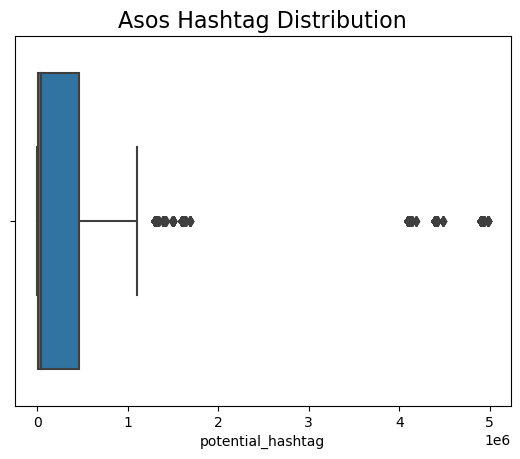

In [130]:
sns.boxplot(x=asos['potential_hashtag'])
plt.title('Asos Hashtag Distribution', fontsize=16)
plt.show()

*If the boxplot shows some extreme outliers, find the interquartile range and decide how to deal with them. The quartiles and IQR can be calculated as follows*

In [132]:
#IQR#

asos[asos['potential_hashtag'] >np.quantile(asos['potential_hashtag'], q=0.75)].count()
#q75


name                 6661
price                6661
#search              6661
#brand               6661
categories           6661
#colour              6661
#1                   6661
#1num                6661
#2                   6661
#2num                6661
potential_hashtag    6661
dtype: int64

I'm going to create a new colum with the potential hashtags above 65% quantile as 'High' (indicates the hashtags that are trendy) or 'Low' for the ones under (indicates the hashtags that are not very trendy). I will use this later for my recommender.


In [133]:
new_list = []

for i in asos['potential_hashtag']:
    if i >np.quantile(asos['potential_hashtag'], q=0.65):
        new_list.append('High')
    else:
        new_list.append('Low')


In [134]:
asos['trendy'] = new_list #target for a classifier model

In [135]:
q25 = np.quantile(asos['potential_hashtag'], q=0.25)
q25


5727.0

## Feature Selection

The idea of feature selection is that you don't have too much multicolinearity, which could **give the algorithm away to the model**. Generally, the rule is that anything above 0.85-0.90 will need to be extensively reviewed before feeding it into the model, and one of the offending columns dropped. 

### CASE: A lower number of columns

In [137]:
#to check the correlation
asos.corr()

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_4983/2372417591.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  asos.corr()


,price,#1num,#2num,potential_hashtag
price,1.000000,0.122991,0.077001,0.123327
#1num,0.122991,1.000000,0.083711,0.999987
#2num,0.077001,0.083711,1.000000,0.088734
potential_hashtag,0.123327,0.999987,0.088734,1.000000


In [138]:
asos = asos.loc[asos['#search'].isin(list(asos['#search'].value_counts()[asos['#search'].value_counts() >10].index))]


In [139]:
asos = asos.loc[asos['#brand'].isin(list(asos['#brand'].value_counts()[asos['#brand'].value_counts() >10].index))]


In [140]:
asos = asos.loc[asos['#colour'].isin(list(asos['#colour'].value_counts()[asos['#colour'].value_counts() >10].index))]


In [141]:
asos = asos.reset_index(drop=True)

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_4983/1736732128.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_matrix = asos.corr()


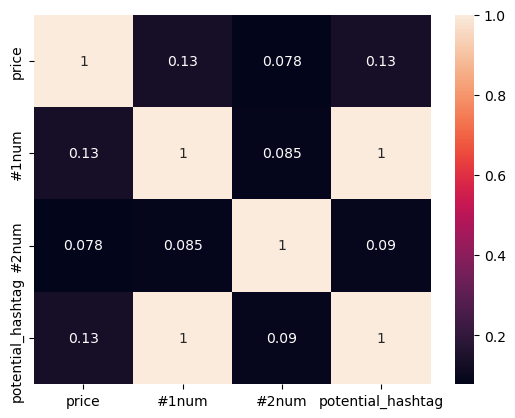

In [142]:
#clearer version

correlations_matrix = asos.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_4983/1530991478.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = asos.corr().loc[:,['potential_hashtag']]


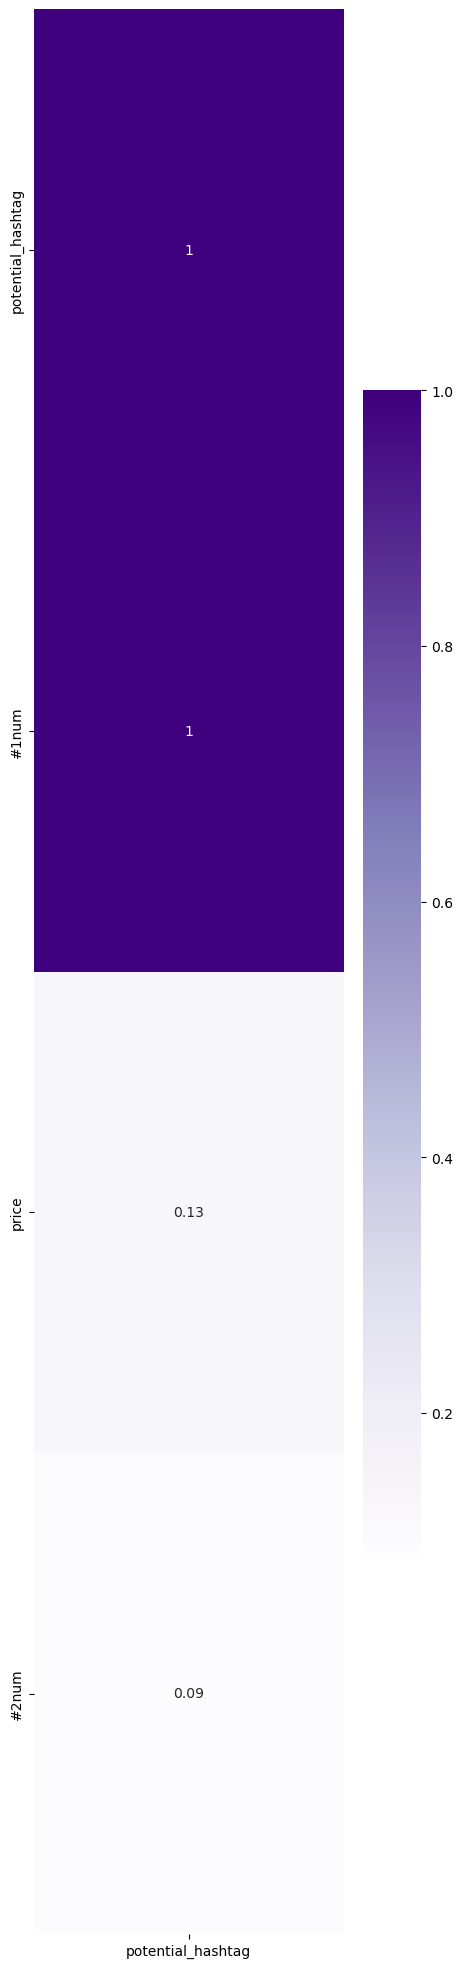

In [143]:
#Visualising the Correlation of columns in a vertical heatmap. This is useful for the number of features on the higher end of the spectrum

corr = asos.corr().loc[:,['potential_hashtag']]
fig, ax = plt.subplots(figsize=(5,25))
ax = sns.heatmap(corr.sort_values(by=['potential_hashtag'],ascending=False), ax=ax,annot=True,cbar=True,cmap="Purples")
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10)
plt.show()

We see that, of course, ther's a big correlation between #1, #2 and potencial_hashtags, so we will NOT use #1 and #2

In [144]:
#sns.pairplot(asos)
#plt.show()

# Building the model

Our model will predict the **number of hashtags** on Instagram based on the features we have selected to train it. 

## Xy Split

In [145]:
y = asos[['potential_hashtag']]
X = asos[['price', '#search', '#brand', 'categories' ,'#colour']]

## Train Test Split

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # default split ratio is 80/20

## Categorical, Numerical Split

In [147]:
#split train data
X_train_numerical = X_train[['price']]
X_train_categorical = X_train[['#search', '#brand', 'categories' ,'#colour']]


#split test data
X_test_numerical = X_test[['price']]
X_test_categorical = X_test[['#search', '#brand', 'categories' ,'#colour']]


## Dealing with numericals

### MinMax Scaler

- **Min-max scaler**
    - squish the data so that the smallest value is 0 and the highest value is 1 (put the data on a scale from 0 to 1)

In [148]:
#Fit ONLY the train set.
MinMaxtransformer = MinMaxScaler().fit(X_train_numerical)

#Train
X_train_normalized = MinMaxtransformer.transform(X_train_numerical)
X_train_minmax = pd.DataFrame(X_train_normalized,columns=X_train_numerical.columns)
#X_train_minmax.head()

#Test
X_test_normalized = MinMaxtransformer.transform(X_test_numerical)
X_test_minmax = pd.DataFrame(X_test_normalized,columns=X_test_numerical.columns)
#X_test_minmax.head()

*Use Min-max scaler:

- When you want features to be between 0 and 1
- For algorithms that assume data is within a particular range (Neural networks for example)
- When data is not normal
- For computer vision problems
- When you want to preserve relative distances between points

## Dealing with categorical data

*When considering categorical columns, we need to understand how we will be encoding them.

- If the unique values in our data is hierarchical, we need to **Ordinally** encode them.\ 

- If, however they are "Yes/No" values, they will need to be **OneHot encoded**. 

### OneHot Encoding

In [149]:
#Fit ONLY the train set. 
encoder = OneHotEncoder(drop='first').fit(X_train_categorical)


#Train
encoded_for_p_train = encoder.transform(X_train_categorical).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_categorical.columns)
X_train_ohe = pd.DataFrame(encoded_for_p_train, columns=cols)
#X_train_ohe.head()


#Test
encoded_for_p_test = encoder.transform(X_test_categorical).toarray()
cols = encoder.get_feature_names_out(input_features=X_test_categorical.columns)
X_test_ohe = pd.DataFrame(encoded_for_p_test, columns=cols)
#X_test_ohe.head()

### MinMaxscaler

In [150]:
###Reset Indices###
X_train_minmax = X_train_minmax.reset_index(drop = True)
X_test_minmax = X_test_minmax.reset_index(drop = True)
X_train_ohe = X_train_ohe.reset_index(drop = True)
X_test_ohe = X_test_ohe.reset_index(drop = True)


#####Concat#####

#Train
X_train_scaled = pd.concat([X_train_minmax,X_train_ohe], axis = 1)

#Test
X_test_scaled = pd.concat([X_test_minmax,X_test_ohe], axis = 1)

## Reset the Incides of our y axes, so that they correspond to the X_train_scaled and X_test_scaled

In [151]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

## Fit Model

Now we are going to try 3 different regression models: DecisionTreeRegressor, LinearRegression and KNeighborsRegressor to see wich one gives us the best results

In [152]:
model1 = DecisionTreeRegressor()
model2 = LinearRegression()
model3 = KNeighborsRegressor()

model_pipeline = [model1, model2, model3]
model_names = ['Decision Tree Regressor', 'Linear Regression', 'KNN']

scores = {}

for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5))
    scores[model_name] = mean_score
print(scores)

{'Decision Tree Regressor': 0.9999917297063767, 'Linear Regression': 0.6299803035591411, 'KNN': 0.9599988735503799}


The results are pretty good in general, but the best one is DecisionTreeRegressor, so we will use that one

# Decision Tree Regressor

In [153]:
DT = DecisionTreeRegressor().fit(X_train_scaled, y_train)

# Validating the model

In [154]:
predictions_train = DT.predict(X_train_scaled)
r2_score(y_train,predictions_train)

0.9999999999999986

In [155]:
predictions_test = DT.predict(X_test_scaled)
r2_score(y_test,predictions_test)

0.9999833439314587

In [156]:
#MSE
mse = mean_squared_error(y_test,predictions_test)
mse

34784505.46752308

In [157]:
#RMSE

rmse = np.sqrt(mean_squared_error(y_test,predictions_test))
rmse

5897.8390506628

Our validation has gone very well. It seems that our model scores well on different meters. But just to be sure, let's save it and test it with unseen data on a new notebook (test machine regression).

# Pickling model and scalers

In [158]:
#Saving the model to a file using pickle

pickle.dump(DT, open('models/regression_model.pkl','wb'))

In [159]:
#Saving the OHE scale to a file using pickle

pickle.dump(encoder, open('encoders/regression_ohe.pkl','wb'))

In [160]:
#Saving the minmax scale to a file using pickle

pickle.dump(MinMaxtransformer, open('transformers/regression_minmax.pkl','wb'))